In [ ]:
!pip install transformers datasets lxml tqdm

In [ ]:
import transformers
import datasets
import torch

print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("PyTorch version:", torch.__version__)

Transformers version: 4.46.2
Datasets version: 3.1.0
PyTorch version: 2.5.1+cu121


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import load_dataset

class DiffAttention(nn.Module):
    """Diff Attention Module"""
    def __init__(self, embed_dim, lambda_init=0.5):
        super(DiffAttention, self).__init__()
        self.embed_dim = embed_dim
        self.lambda_ = nn.Parameter(torch.tensor(lambda_init))
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q1, Q2 = torch.chunk(Q, 2, dim=-1)  # [batch_size, seq_len, embed_dim // 2]
        K1, K2 = torch.chunk(K, 2, dim=-1)

        scale = (self.embed_dim // 2) ** 0.5
        A1 = F.softmax(torch.matmul(Q1, K1.transpose(-2, -1)) / scale, dim=-1)  # [batch_size, seq_len, seq_len]
        A2 = F.softmax(torch.matmul(Q2, K2.transpose(-2, -1)) / scale, dim=-1)  # [batch_size, seq_len, seq_len]

        diff_attention = A1 - self.lambda_ * A2
        attention_output = torch.matmul(diff_attention, V)
        return attention_output, A1, A2, diff_attention


class DiffBart(nn.Module):
    """BART with Diff Attention in the Encoder"""
    def __init__(self, model_name="facebook/bart-base", lambda_init=0.5):
        super(DiffBart, self).__init__()
        self.bart = BartForConditionalGeneration.from_pretrained(model_name)
        self.diff_attention = DiffAttention(self.bart.config.d_model, lambda_init)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        # エンコーダの入力を取得
        encoder_outputs = self.bart.model.encoder(input_ids, attention_mask=attention_mask)

        # Diff Attention を適用
        diff_output, A1, A2, diff_attention = self.diff_attention(encoder_outputs.last_hidden_state)

        # エンコーダ出力を置き換え
        encoder_outputs.last_hidden_state = diff_output

        # デコーダによる生成
        outputs = self.bart.model.decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=encoder_outputs.last_hidden_state,
            encoder_attention_mask=attention_mask,
        )
        logits = self.bart.lm_head(outputs.last_hidden_state)

        return logits, A1, A2, diff_attention

In [32]:
from datasets import load_dataset
from transformers import BartTokenizer
from datasets import load_from_disk
from torch.utils.data import DataLoader
from pathlib import Path
from transformers import AdamW
from transformers import default_data_collator
import torch.nn as nn
import torch

# トークナイザーの準備
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# データセットのダウンロード（1-10%をサンプル）
train_dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:10%]")
val_dataset = load_dataset("cnn_dailymail", "3.0.0", split="validation[:1%]")
test_dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:1%]")

# データ前処理関数
def preprocess_data(batch):
    inputs = tokenizer(batch["article"], max_length=512, truncation=True, padding="max_length")
    outputs = tokenizer(batch["highlights"], max_length=128, truncation=True, padding="max_length")
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "decoder_input_ids": outputs["input_ids"],
        "decoder_attention_mask": outputs["attention_mask"]
    }

# データセットの前処理
train_dataset = train_dataset.map(preprocess_data, batched=True)
val_dataset = val_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# 保存先ディレクトリ
save_dir = Path("/content/drive/MyDrive/Colab Notebooks/data/cnn_dailymail_1percent_preprocessed")
save_dir.mkdir(parents=True, exist_ok=True)

# ディスクに保存
train_dataset.save_to_disk(save_dir / "train_dataset")
val_dataset.save_to_disk(save_dir / "val_dataset")
test_dataset.save_to_disk(save_dir / "test_dataset")
print(f"前処理済みデータセットが保存されました: {save_dir}")

# ディスクから読み込む
train_dataset = load_from_disk(save_dir / "train_dataset")
val_dataset = load_from_disk(save_dir / "val_dataset")
print(f"前処理済みデータセットが読み込まれました。学習サンプル数: {len(train_dataset)}")

# 最初のデータを確認
print(train_dataset[0])

Map:   0%|          | 0/28711 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/28711 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/134 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/115 [00:00<?, ? examples/s]

前処理済みデータセットが保存されました: /content/drive/MyDrive/Colab Notebooks/data/cnn_dailymail_1percent_preprocessed
前処理済みデータセットが読み込まれました。学習サンプル数: 28711
{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino,

In [ ]:
# データローダーの作成
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=default_data_collator
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=default_data_collator
)

# データ確認
for batch in train_dataloader:
    print(batch["input_ids"].shape)  # [batch_size, max_length]
    print(batch["decoder_input_ids"].shape)  # [batch_size, max_length]
    break

# モデルの初期化
model = DiffBart(lambda_init=0.1)  # DiffBart を適切に定義している必要があります
model.to("cuda")

# 損失関数とオプティマイザ
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = AdamW(model.parameters(), lr=5e-5)

# 学習ループ
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # トレーニングループ
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        decoder_input_ids = batch["decoder_input_ids"].to("cuda")

        # モデルの出力
        logits, A1, A2, diff_attention = model(input_ids, attention_mask, decoder_input_ids)

        # 損失計算
        loss = criterion(logits.view(-1, tokenizer.vocab_size), decoder_input_ids.view(-1))
        total_train_loss += loss.item()

        # 逆伝播とパラメータ更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # バリデーションループ
    model.eval()
    total_val_loss = 0
    max_val_batches = 10  # 最大で使用するバリデーションバッチ数
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            if i >= max_val_batches:
                break
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            decoder_input_ids = batch["decoder_input_ids"].to("cuda")

            # モデルの出力
            logits, _, _, _ = model(input_ids, attention_mask, decoder_input_ids)

            # 損失計算
            loss = criterion(logits.view(-1, tokenizer.vocab_size), decoder_input_ids.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / max_val_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss (partial): {avg_val_loss:.4f}")

# モデル重みの保存
model_save_path = "/content/drive/MyDrive/Colab Notebooks/weights/diffbart.pth"
torch.save(model.state_dict(), model_save_path)
print(f"モデルが保存されました: {model_save_path}")

torch.Size([16, 512])
torch.Size([16, 128])


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
import torch
from datasets import load_from_disk
from transformers import BartTokenizer

# モデルとトークナイザーの準備
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model_save_path = "/content/drive/MyDrive/Colab Notebooks/weights/diffbart.pth"  # 保存されたモデルのパス

# DiffBartモデルを再インスタンス化
model = DiffBart()  # DiffBartはあなたの実装済みのモデルクラス
model.load_state_dict(torch.load(model_save_path))  # 保存済みの重みをロード
model.to("cuda")
model.eval()  # 評価モードに設定
print("モデルがロードされました。")

# 前処理済みのテストデータセットをロード
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/data/cnn_dailymail_1percent_preprocessed/test_dataset"
test_dataset = load_from_disk(test_dataset_path)
print(f"テストデータセットがロードされました。サンプル数: {len(test_dataset)}")

# テストデータローダーの作成
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 16
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # テストではシャッフル不要
    collate_fn=default_data_collator
)

print("テストデータローダーがインスタンス化されました。")

<ipython-input-34-f4bcd00ffcef>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # 保存済みの重みをロード


モデルがロードされました。
テストデータセットがロードされました。サンプル数: 115
テストデータローダーがインスタンス化されました。


Visualizing Attention Maps...


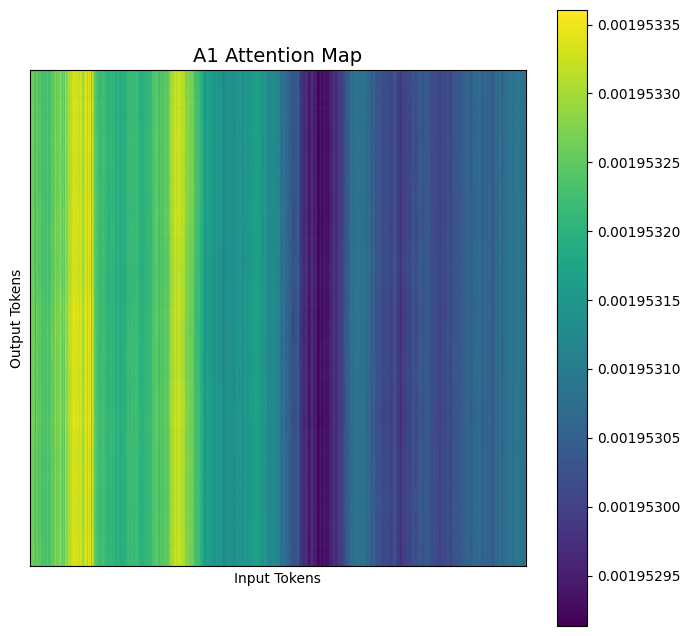

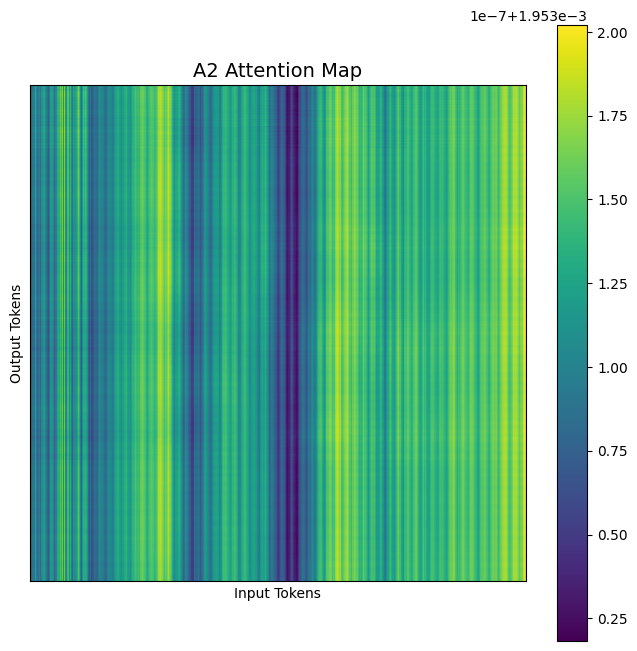

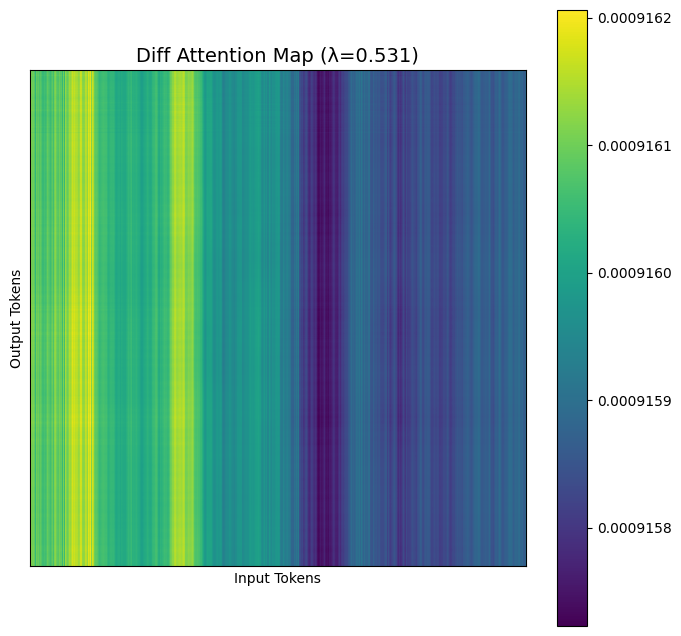

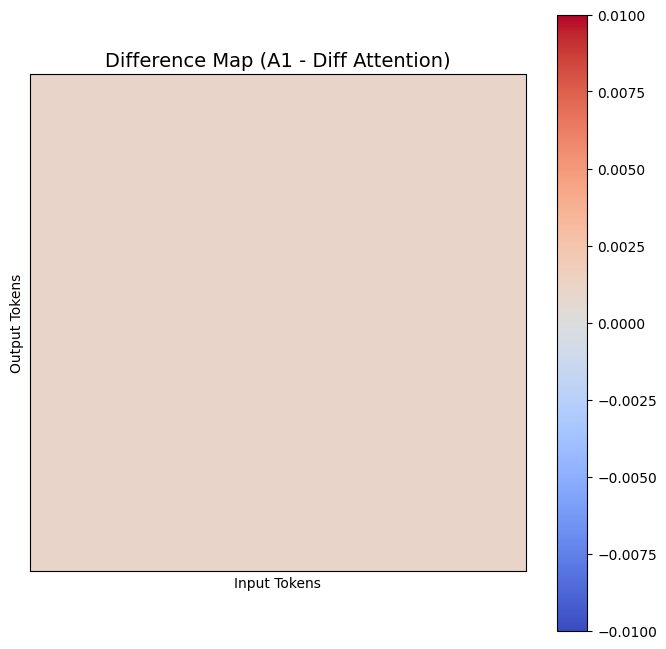

In [35]:
import matplotlib.pyplot as plt
import torch

# 注意マップを可視化する関数
def visualize_attention_map(attention_map, title, lambda_value=None):
    """
    attention_map: 注意マップ (seq_len x seq_len)
    title: プロットのタイトル
    lambda_value: Diff-Attentionにおけるλ値（オプション）
    """
    plt.figure(figsize=(8, 8))
    attention = attention_map.detach().cpu().numpy()
    plt.imshow(attention, cmap="viridis")
    plt.colorbar()
    if lambda_value is not None:
        title += f" (λ={lambda_value:.3f})"
    plt.title(title, fontsize=14)
    plt.xlabel("Input Tokens")
    plt.ylabel("Output Tokens")
    plt.xticks([])  # 横軸ラベルを非表示
    plt.yticks([])  # 縦軸ラベルを非表示
    plt.show()


# 差分マップを可視化する関数
def visualize_difference_map(diff_map, title):
    """
    diff_map: A1 - Diff Attentionの差分
    title: プロットのタイトル
    """
    plt.figure(figsize=(8, 8))
    diff = diff_map.detach().cpu().numpy()  # GPUからCPUに移動してnumpy化
    plt.imshow(diff, cmap="coolwarm", vmin=-0.01, vmax=0.01)  # 差分を強調
    plt.colorbar()
    plt.title(title, fontsize=14)
    plt.xlabel("Input Tokens")
    plt.ylabel("Output Tokens")
    plt.xticks([])  # 横軸ラベルを非表示
    plt.yticks([])  # 縦軸ラベルを非表示
    plt.show()


# テスト用の文章
test_text = "AI technology is advancing rapidly and is expected to play a significant role in various fields, including healthcare, transportation, and education. Researchers believe that AI can enhance natural language processing capabilities, enabling better human-computer interaction. Additionally, AI is being integrated into robotics, making systems more efficient and adaptable, a cute cat."

# トークナイズ（明確に設定）
test_input = tokenizer(
    test_text,
    return_tensors="pt",
    padding="max_length",  # 必要なパディング
    truncation=True,  # 長い入力をカット
    max_length=512  # モデルの最大長に合わせる
).to("cuda")

# デコーダー入力を作成
decoder_start_token_id = tokenizer.bos_token_id
decoder_input_ids = torch.tensor([[decoder_start_token_id]], device="cuda")  # デコーダーの開始トークン

# モデルの推論と注意マップ取得
model.eval()
with torch.no_grad():
    # モデルの出力と注意マップ取得
    logits, A1, A2, diff_attention = model(
        input_ids=test_input["input_ids"],
        attention_mask=test_input["attention_mask"],
        decoder_input_ids=decoder_input_ids
    )

    # 学習したλ値を取得
    lambda_value = model.diff_attention.lambda_.item()

# 注意マップの可視化
print("Visualizing Attention Maps...")
visualize_attention_map(A1[0], "A1 Attention Map")
visualize_attention_map(A2[0], "A2 Attention Map")
visualize_attention_map(diff_attention[0], "Diff Attention Map", lambda_value=lambda_value)

# A1とDiff-Attentionの差分マップを可視化
difference_map = A1[0] - diff_attention[0]
visualize_difference_map(difference_map, "Difference Map (A1 - Diff Attention)")